<a href="https://colab.research.google.com/github/cc-ca/projet-impression-3d/blob/main/projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet de détection de défaut en impression 3d

Ce projet a pour but de faire de la détection de défaut pendant une impression 3d.<br><br>
Le but est d'éviter le gachis de bobines plastiques et non de garantir une impression parfaite. En effet dans de nombreux cas des defauts superficiels ne rendent pas inutilisables les pièces imprimées.<br><br>
C'est pourquoi nous concentrerons sur les gros défaut qui peuvent venir abimer l'imprimante en plus de gacher du plastique et de l'énergie.<br><br>
Nous cherchons donc à faire un modèle capable de classifier à partir d'une image la catégorie de l'impression entre pas de défaut, pièce décollée du plateau, et défaut spaghetti.

##Imports préliminaires (librairies et dataset)

In [1]:
import os
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import random
import time

Pour ce projet nous avons utilisé comme base un dataset trouvé sur kaggle ([Lien Dataset Kaggle](https://www.kaggle.com/datasets/mikulhe/3d-printing-errors/)). <br>Nous n'avons gardé que les catégories qui nous intéressent et l'avons enrichi de données que nous avons crées en prenant des photos des imprimantes 3d de l'ISEN.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
# On se déplace dans notre espace de travail.
# Prévoir le dossier où se placer ou modifier le chemin ci-dessous.
%cd "/content/gdrive/MyDrive/projet impression 3d"

/content/gdrive/MyDrive/projet impression 3d


Faites un raccourcis du dataset dans le dossier correspondant au chemin ci-dessus:

[Lien Google Drive du dataset](https://drive.google.com/drive/folders/1y6OoWPs9WjeynMaLI7R-NipD_thyCNjw?usp=sharing)

# Préparation des données

In [4]:
dataset_path = 'dataset_colab' # Chemin du dataset par rapport à l'espace de travail (par defaut: projet impression 3d)
RESIZE_SIZE = (255, 255)       # Résolution sous laquelle les images sont redimensionné en entrée du modèle

In [5]:
def load_data(dataset_path):
    data = [] # Liste des images contenu dans dataset_path
    labels = [] # Liste des labels de chaque image

    # Pour chaque image contenu dans dataset_path,
    # l'importe puis la prépare pour l'entrainement
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)

        if os.path.isdir(folder_path):
            label = folder.lower()   # Utilisez le nom du dossier comme label
            print(label)

            for filename in os.listdir(folder_path):
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, RESIZE_SIZE) # Force la taille d'une image pour qu'elle corresponde à celle utilisée lors de l'entraînement
                data.append(img)
                labels.append(label)

    data = np.array(data) / 255.0    # Normalisez les valeurs des pixels
    labels = np.array(labels)

    return data, labels

In [6]:
def shuffle_data(data, labels):
    combined_data = list(zip(data,labels))

    # Mélange les données
    random.shuffle(combined_data)

    # Divisez à nouveau la liste combinée en deux listes distinctes
    data,labels = zip(*combined_data)

    labels = np.array(labels)
    data = np.array(data)

    return data, labels

In [7]:
data, labels = load_data(dataset_path)

ok
bed_not_stick
spaghetti


In [8]:
# On défini un dictionnaire de mapping (catégorie -> numéro) pour chaque labels précédement listé
categorie_mapping = {
    "ok": 0,
    "bed_not_stick": 1,
    "spaghetti": 2
}

# Utiliser NumPy pour convertir les catégories en numéros
labels = np.array([categorie_mapping[c] for c in labels])

In [9]:
print('Taille du dataset: ', len(labels))
print('Catégorie de la dernière image: ', labels[-1])

Taille du dataset:  604
Catégorie de la dernière image:  2


In [10]:
data, labels = shuffle_data(data, labels)

In [11]:
print('Taille du dataset: ', len(labels))
print('Catégorie de la dernière image: ', labels[-1])

Taille du dataset:  604
Catégorie de la dernière image:  0


# Création du modèle

In [14]:
drop_out = 0.3
model = keras.Sequential([
    layers.Conv2D(64, (7, 7), activation='relu', input_shape=(*RESIZE_SIZE, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (4, 4), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),

    layers.Dense(64, activation='relu'),
    layers.Dropout(drop_out),
    layers.Dense(32, activation='relu'),
    layers.Dropout(drop_out),

    layers.Dense(len(categorie_mapping), activation='softmax')
])

# Compilez le modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 249, 249, 64)      3200      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 124, 124, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 121, 121, 128)     131200    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 60, 60, 128)       0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 460800)            0         
                                                                 
 dense_3 (Dense)             (None, 64)               

In [15]:
from keras.callbacks import ModelCheckpoint

# Décommenter la ligne ci-dessous pour sauvegarder le meilleur modèle. (Attention assez lourd !)
#checkpoint = ModelCheckpoint('meilleur_modele.h5', monitor='val_accuracy', save_best_only=True)

In [16]:
# Entraine le modèle.
# Décommenter la ligne correspondante pour sauvegarder ou non le meilleur modèle. (voir la cellule précédente)
model.fit(data, labels, epochs=15, validation_split=0.20, batch_size=8)
#model.fit(data, labels, epochs=15, validation_split=0.20, batch_size=8, callbacks=[checkpoint])

Epoch 1/15
61/61 [==============================] - 11s 57ms/step - loss: 1.2029 - accuracy: 0.4700 - val_loss: 1.0004 - val_accuracy: 0.5620
Epoch 2/15
61/61 [==============================] - 2s 41ms/step - loss: 1.0091 - accuracy: 0.5072 - val_loss: 0.9658 - val_accuracy: 0.5785
Epoch 3/15
61/61 [==============================] - 3s 43ms/step - loss: 0.9133 - accuracy: 0.5921 - val_loss: 0.9161 - val_accuracy: 0.6116
Epoch 4/15
61/61 [==============================] - 3s 45ms/step - loss: 0.7354 - accuracy: 0.6646 - val_loss: 0.8633 - val_accuracy: 0.5702
Epoch 5/15
61/61 [==============================] - 3s 43ms/step - loss: 0.6613 - accuracy: 0.7350 - val_loss: 0.8841 - val_accuracy: 0.6529
Epoch 6/15
61/61 [==============================] - 3s 43ms/step - loss: 0.5684 - accuracy: 0.7888 - val_loss: 1.1299 - val_accuracy: 0.6694
Epoch 7/15
61/61 [==============================] - 3s 44ms/step - loss: 0.3868 - accuracy: 0.8551 - val_loss: 1.0468 - val_accuracy: 0.6612
Epoch 8/15
6

On sauvegarde les meilleurs poids pour le modèle dans ce dossier Google Drive:

[Lien du Google Drive des modèles sauvegardé](https://drive.google.com/drive/folders/124cj4R3cZ6kY-yXq6uaot2LCysKZWUJ8?usp=drive_link)

In [17]:
# Décommenter pour sauvegarde le modèle actuel
model.save('model.keras')

# Prédiction

In [18]:
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, RESIZE_SIZE) # Force la taille d'une image pour qu'elle corresponde à celle utilisée lors de l'entraînement
    img = img / 255.0                  # Normalisez les valeurs des pixels
    img = np.expand_dims(img, axis=0)  # Ajoutez une dimension pour représenter le lot (batch)

    return img

In [19]:
def predict_defect(model, image_path):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)

    # Interprétez les prédictions
    class_labels = list(categorie_mapping.keys())
    predicted_class = class_labels[np.argmax(predictions)]

    return predicted_class

In [20]:
def predict(dir):
    print(dir)
    """ Affiche les prédictions pour l'ensemble des images d'un dossier
    """
    resultf=""
    nb_total=0
    nb_positif=0

    for filename in os.listdir(dir):
        nb_total+=1

        result = predict_defect(model, dir +"/" + filename)
        if result.upper()==dir[4:].upper():
            nb_positif+=1

        resultf= resultf + "prédiction pour"+ filename + " : "+ str(result) +"\n"

    print(resultf)
    print(str((nb_positif*100)/nb_total) + " % de précision")


In [21]:
from PIL import Image
import matplotlib.pyplot as plt

def vignette_random(dir):
    """ Affiche la prédiction pour un image au hasard dans un dossier donné
    """
    L=[]

    # Choisi une image au hasard parmis les images d'un dossier
    for filename in os.listdir(dir):
        L.append(filename)
    file_alea = L[random.randint(0, (len(L)-1))]

    image_path = dir +"/" + file_alea
    result = predict_defect(model, image_path)

    # Affiche la vignette et sa prédiction
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print (result)


In [22]:
predict("testok")

testok
1/1 [==============================] - 0s 17ms/step
prédiction pourok.jpg : ok
prédiction pourspaghetti.jpg : ok
prédiction pourok3.jpg : ok
prédiction pourok5.png : spaghetti
prédiction pourWIN_20231010_15_02_24_Pro.jpg : ok
prédiction pourWIN_20231010_15_02_40_Pro.jpg : ok
prédiction pourWIN_20231010_15_03_00_Pro.jpg : ok
prédiction pourWIN_20231010_15_03_09_Pro.jpg : ok
prédiction pourWIN_20231010_15_03_11_Pro.jpg : ok
prédiction pourWIN_20231010_15_03_18_Pro.jpg : ok
prédiction pourWIN_20231010_15_03_24_Pro.jpg : ok
prédiction pourWIN_20231010_15_03_29_Pro.jpg : ok
prédiction pourWIN_20231010_15_03_56_Pro.jpg : ok
prédiction pourWIN_20231010_15_03_58_Pro.jpg : ok
prédiction pourWIN_20231010_15_04_02_Pro.jpg : ok
prédiction pourWIN_20231010_15_04_05_Pro.jpg : spaghetti

87.5 % de précision


In [23]:
predict("testspaghetti")

testspaghetti
1/1 [==============================] - 0s 19ms/step
prédiction pourfailedprint2_img_5eb0af2d67ead.jpg : spaghetti
prédiction pourspaghetti_11_jpg.rf.8f8ab1a10807e3e51c4075a1a018ce3b.jpg : spaghetti
prédiction pourspaghetti_91_jpg.rf.2b147f68c7718049a4c11374c5f190be.jpg : spaghetti
prédiction pourimag-12-_jpg.rf.30b4d2d01cbe881c76ffb7cd4aa30d4c.jpg : ok
prédiction pourDv-Hh80U0AABjlw_jpg.rf.6116d29abb60be092c1930f2765318db.jpg : spaghetti
prédiction pourspaghetti_52_jpg.rf.66888e51d1873df0cae0aaa48e07369f.jpg : ok
prédiction pourspaghetti_73_jpg.rf.5c6d77c9cee2ba4df4e3052c8e9ecdc3.jpg : spaghetti
prédiction pourspaghetti_70_jpg.rf.02d93e279aaca215b2131a0cc614507a.jpg : spaghetti
prédiction pourimag-90-_jpg.rf.4b9eacbcb46c3c32db58fb5f7c22ed4c.jpg : spaghetti
prédiction pourspaghetti_49_jpg.rf.2f51e66161f920f5704ae3e81e089435.jpg : spaghetti
prédiction pourspaghetti_1_jpg.rf.4b6bc66a3d72ead9fc1592820c153ee8.jpg : ok
prédiction pour336642593_1586539821825588_29026091521999098

1/1 [==============================] - 0s 16ms/step


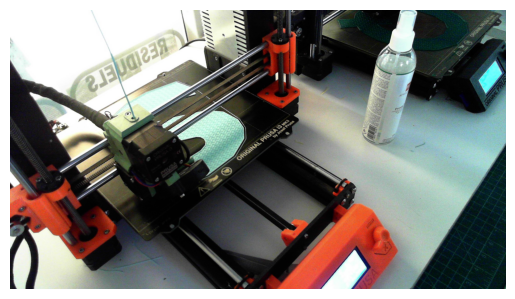

ok


In [24]:
vignette_random("testok")

In [1]:
vignette_random("testspaghetti")

NameError: name 'vignette_random' is not defined

Après avoir entrainé notre modèle sur google collab nous avons fait un deuxième notebook pour le charger et l'utiliser avec une webcam en direct sur un ordinateur.